# craters_cnn_xception_full
In this notebook I use the full Xception model on the clean training set. It is smaller though, so it will be interesting to see which one is better on the test set. Another difference here is that I will make the train, val and test set out of the ~900 craters/900 non-craters instead of ~1200 total which I used before. 

In [25]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Add,Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from PIL import Image
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix


## Generate a keras Dataset

In [2]:
data_fld = '/home/ahoag/ML/mars/attempt2/images_for_cnn'

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)

Found 1500 files belonging to 2 classes.
Using 1200 files for training.
Found 1500 files belonging to 2 classes.
Using 300 files for validation.


## Visualize the data

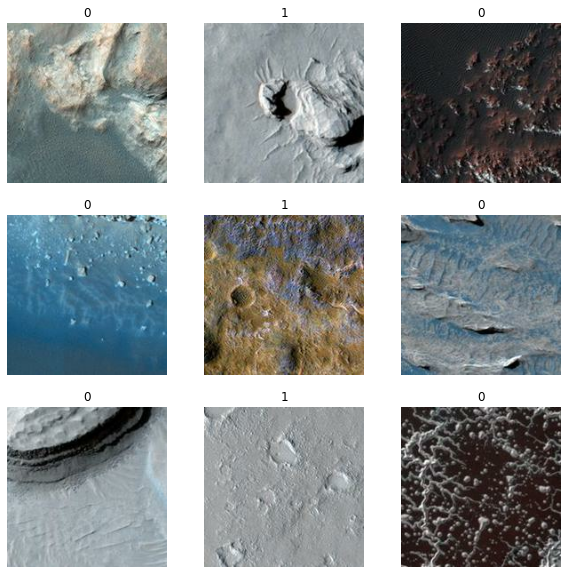

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # Take grabs items at the batch level
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

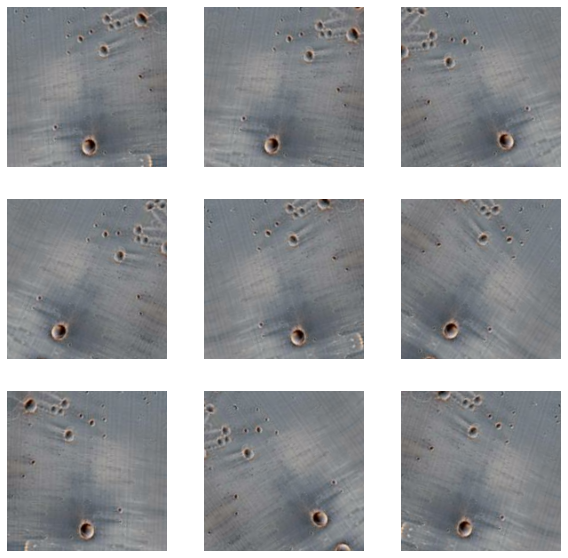

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Configure the dataset for performance

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model
We'll build the full-blown Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

Note that:

- We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
- We include a Dropout layer before the final classification layer.

In [26]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = Add()([x, residual])
        previous_block_activation = x

    return x

In [28]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [29]:
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x) 
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    return x

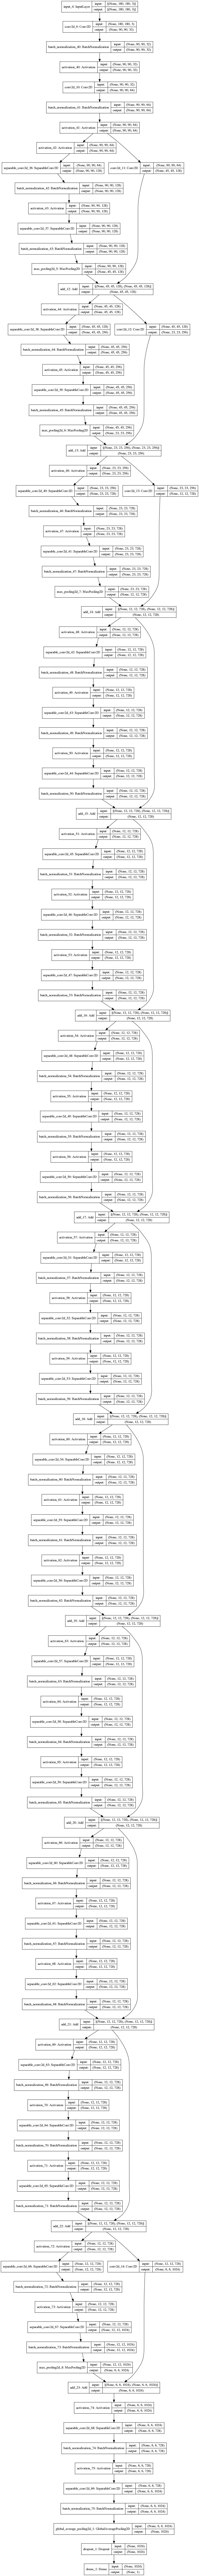

In [33]:
model = make_model(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 90, 90, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 90, 90, 32)   128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 90, 90, 32)   0           batch_normalization_40[0][0]     
______________________________________________________________________________________________

## Train the model

In [35]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("/home/ahoag/ML/mars/attempt3/cnn_saved_epochs/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
38/38 [==============================] - 100s 3s/step - loss: 0.9224 - accuracy: 0.5482 - val_loss: 0.6922 - val_accuracy: 0.5467
Epoch 2/20
38/38 [==============================] - 96s 3s/step - loss: 0.7802 - accuracy: 0.5465 - val_loss: 0.6916 - val_accuracy: 0.5467
Epoch 3/20
38/38 [==============================] - 96s 3s/step - loss: 0.7326 - accuracy: 0.5271 - val_loss: 0.7049 - val_accuracy: 0.4533
Epoch 4/20
38/38 [==============================] - 96s 3s/step - loss: 0.7733 - accuracy: 0.5694 - val_loss: 0.6967 - val_accuracy: 0.4533
Epoch 5/20
38/38 [==============================] - 94s 2s/step - loss: 0.7697 - accuracy: 0.5051 - val_loss: 0.7078 - val_accuracy: 0.4533
Epoch 6/20
38/38 [==============================] - 95s 2s/step - loss: 0.7683 - accuracy: 0.5395 - val_loss: 0.6894 - val_accuracy: 0.5367
Epoch 7/20
38/38 [==============================] - 94s 2s/step - loss: 0.7687 - accuracy: 0.5393 - val_loss: 0.6913 - val_accuracy: 0.5333
Epoch 8/20
38/38 [=

In [38]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("/home/ahoag/ML/mars/attempt3/cnn_saved_epochs/save_at_{epoch}_start21.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history2 = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
38/38 [==============================] - 96s 2s/step - loss: 0.6649 - accuracy: 0.5816 - val_loss: 1.2331 - val_accuracy: 0.5667
Epoch 2/20
38/38 [==============================] - 93s 2s/step - loss: 0.6824 - accuracy: 0.6213 - val_loss: 0.7454 - val_accuracy: 0.5600
Epoch 3/20
38/38 [==============================] - 95s 2s/step - loss: 0.6557 - accuracy: 0.6382 - val_loss: 0.7404 - val_accuracy: 0.6000
Epoch 4/20
38/38 [==============================] - 92s 2s/step - loss: 0.6375 - accuracy: 0.6453 - val_loss: 0.6928 - val_accuracy: 0.5967
Epoch 5/20
38/38 [==============================] - 93s 2s/step - loss: 0.6450 - accuracy: 0.6011 - val_loss: 0.7370 - val_accuracy: 0.5967
Epoch 6/20
38/38 [==============================] - 93s 2s/step - loss: 0.6436 - accuracy: 0.6339 - val_loss: 0.6797 - val_accuracy: 0.6100
Epoch 7/20
38/38 [==============================] - 93s 2s/step - loss: 0.6356 - accuracy: 0.6234 - val_loss: 1.5567 - val_accuracy: 0.5400
Epoch 8/20
38/38 [==

## Evaluate the model

In [39]:
all_history = {}
for key in history.history:
    all_history[key] = history.history[key]
    all_history[key].extend(history2.history[key])

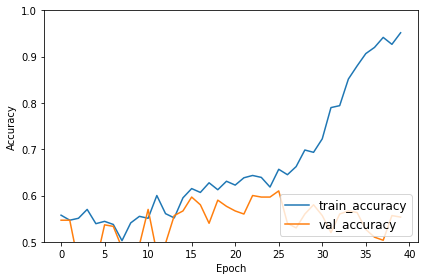

In [41]:
plt.plot(all_history['accuracy'], label='train_accuracy')
plt.plot(all_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right',fontsize=12)
plt.tight_layout()
plt.savefig('../attempt3/training_attempt3.png')

We get ~90% accuracy on the validation set after running for 60 epochs! This is significantly better than the previous run with the worse training set! 

## Attempt to train for longer to see if model keeps improving

In [55]:
callbacks = [
    keras.callbacks.ModelCheckpoint("/home/ahoag/ML/mars/attempt2/cnn_saved_epochs/save_at_{epoch}_2ndround.h5"),
]

history2 = model.fit(
    train_ds, epochs=20, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
38/38 [==============================] - 54s 1s/step - loss: 0.1144 - accuracy: 0.9542 - val_loss: 0.2084 - val_accuracy: 0.9233
Epoch 2/20
38/38 [==============================] - 54s 1s/step - loss: 0.1264 - accuracy: 0.9558 - val_loss: 0.2895 - val_accuracy: 0.8933
Epoch 3/20
38/38 [==============================] - 54s 1s/step - loss: 0.1397 - accuracy: 0.9467 - val_loss: 0.3771 - val_accuracy: 0.8767
Epoch 4/20
38/38 [==============================] - 53s 1s/step - loss: 0.1719 - accuracy: 0.9417 - val_loss: 0.2959 - val_accuracy: 0.8967
Epoch 5/20
38/38 [==============================] - 53s 1s/step - loss: 0.1002 - accuracy: 0.9625 - val_loss: 0.2949 - val_accuracy: 0.8967
Epoch 6/20
38/38 [==============================] - 53s 1s/step - loss: 0.1190 - accuracy: 0.9558 - val_loss: 0.3195 - val_accuracy: 0.8933
Epoch 7/20
38/38 [==============================] - 53s 1s/step - loss: 0.1134 - accuracy: 0.9558 - val_loss: 0.3451 - val_accuracy: 0.8900
Epoch 8/20
38/38 [==

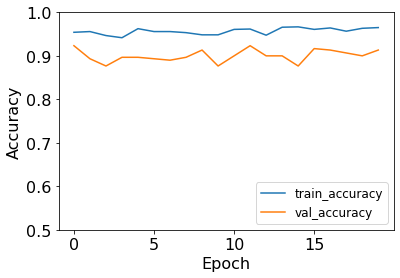

In [57]:
plt.plot(history2.history['accuracy'], label='train_accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right',fontsize=12)
# plt.tight_layout()
# plt.savefig('../attempt2/training_attempt2.png')

No improvement over an additional 20 epochs. Discard these epochs.

In [70]:
best_model_save_file = '../attempt2/cnn_saved_epochs/save_at_60.h5'
best_model = keras.models.load_model(best_model_save_file)

## Run inference on new data
Note that data augmentation and dropout are inactive at inference time.

In [13]:
test_fld = '/home/ahoag/ML/mars/attempt2/test_cnn'

These all look good! I think this is working! Maybe coincidence so we will want to make a more thorough test set. 

In [16]:
max_val_acc = max(history.history['val_accuracy'])
history.history['val_accuracy'].index(max_val_acc)+1 

60

In [56]:
print(f"Maximum val_accuracy = {max_val_acc}")

Maximum val_accuracy = 0.9200000166893005


## Evaluate model (at epoch 60) on test set

In [17]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_fld,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)


Found 304 files belonging to 2 classes.


i=0,label=1
i=1,label=0
i=2,label=1
i=3,label=1
i=4,label=1
i=5,label=0
i=6,label=0
i=7,label=0
i=8,label=0


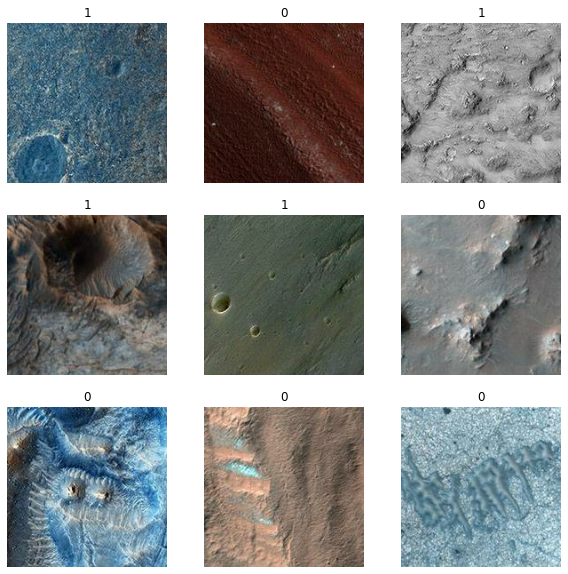

In [18]:
# Take a look at some of these to make sure they were loaded in right
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        print(f"i={i},label={labels[i]}")
        ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [72]:
# Load in test images and labels
result = best_model.evaluate(test_ds)

10/10 [==============================] - 3s 286ms/step - loss: 0.2859 - accuracy: 0.8882


Looks like my test-set accuracy is ~88%. This is super good! Let's look at confusion matrix

In [73]:
test_predictions = []
test_labels = []
test_probs = []
for x, y in test_ds:
    new_predictions = best_model.predict(x)[:,0]
    test_predictions.extend(list(map(round,new_predictions)))
    test_labels.extend(list(map(round,y.numpy())))
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        test_probs.append(pred_float)
    

In [79]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = 'd'
    fmt_norm = '.2f'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt)+f' ({format(cm_norm[i, j], fmt_norm)})',
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

[[141   9]
 [ 25 129]]


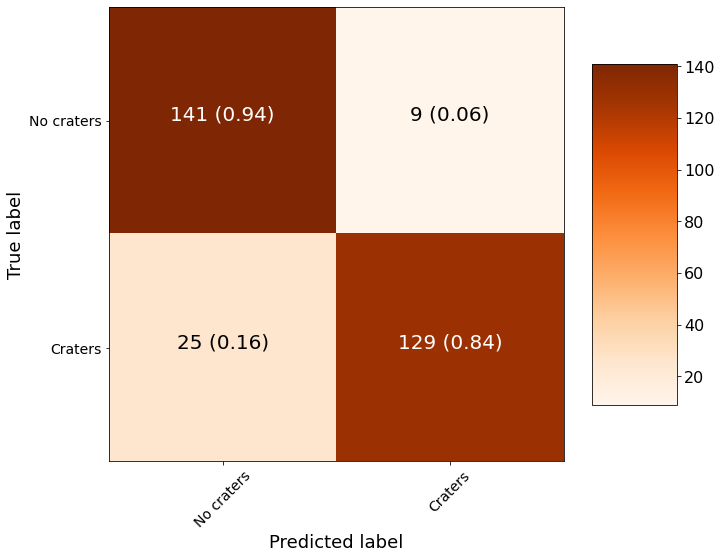

In [81]:
cm = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(cm, classes = ['No craters', 'Craters'],
                      title = '',
                     )
plt.savefig('../attempt2/confusion_matrix_attempt2.png')

Like the initial model, this model is very good at identifying what is NOT a crater. It has a harder time picking up all of the craters. Another way of saying this is the precision is very good but recall not as good. Let's compare ROC AUC curve to previous model.

In [76]:
train_predictions = []
train_labels = []
train_probs = []
for x, y in train_ds:
    new_predictions = best_model.predict(x)[:,0]
    train_predictions.extend(list(map(round,new_predictions)))
    train_labels.extend(list(map(round,y.numpy())))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        train_probs.append(pred_float)
    


In [42]:
previous_model_save_file = '../cnn_saved_epochs/best_model_epoch53.h5'
previous_model = keras.models.load_model(previous_model_save_file)

In [44]:
prevmodel_test_fld = '../test_set_attempt1'
prevmodel_test_ds = tf.keras.preprocessing.image_dataset_from_directory(prevmodel_test_fld,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)

Found 419 files belonging to 2 classes.


In [45]:
prevmodel_test_predictions = []
prevmodel_test_labels = []
prevmodel_test_probs = []
for x, y in prevmodel_test_ds:
    new_predictions = previous_model.predict(x)[:,0]
    prevmodel_test_predictions.extend(list(map(round,new_predictions)))
    prevmodel_test_labels.extend(list(map(round,y.numpy())))
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        prevmodel_test_probs.append(pred_float)

In [67]:
def evaluate_model(predictions, probs, train_predictions, train_probs,prevmodel_predictions,prevmodel_probs):
    """
    Compare machine learning model to baseline and previous model performance.
    Computes statistics and shows ROC curve.
    ---INPUT---
    predictions:    predicted classes in the test set
    
    """
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    previous = {}
    
    previous['recall'] = recall_score(prevmodel_test_labels, [1 for _ in range(len(prevmodel_test_labels))])
    previous['precision'] = precision_score(prevmodel_test_labels, [1 for _ in range(len(prevmodel_test_labels))])
    previous['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)}'
              f' Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    prevmodel_fpr, prevmodel_tpr, _ = roc_curve(prevmodel_test_labels, prevmodel_probs)
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(prevmodel_fpr, prevmodel_tpr, 'g', label = 'Xception (lg train set, quick data)')
    plt.plot(model_fpr, model_tpr, 'r', label = 'Xception (sm train set, good data)' )
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.savefig('../attempt2/roc_auc_compare1and2.png')

Recall Baseline: 1.0 Test: 0.84 Train: 0.96
Precision Baseline: 0.51 Test: 0.93 Train: 0.97
Roc Baseline: 0.5 Test: 0.95 Train: 0.99


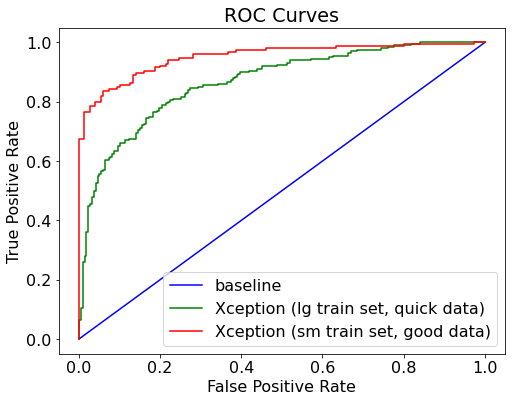

In [68]:
evaluate_model(test_predictions,test_probs,train_predictions, train_probs,
              prevmodel_test_predictions,prevmodel_test_probs)

In [63]:
roc_auc_score(test_labels, test_probs)

0.950865800865801

In [78]:
roc_auc_score(prevmodel_test_labels, prevmodel_test_probs)

0.8666666666666666

In [83]:
false_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_negatives.append(fn_dict)


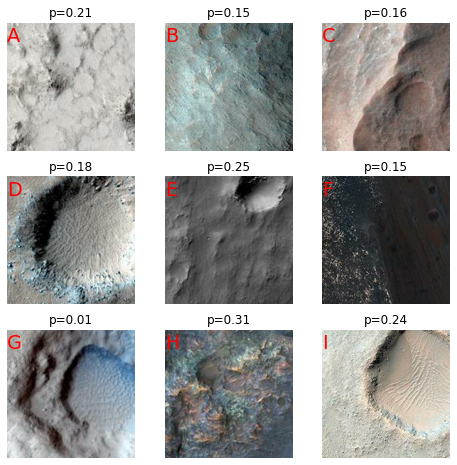

In [86]:
# inspect false negatives
# np.random.shuffle(false_negatives)
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
    plt.imshow(false_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = false_negatives[i]['pred']
    plt.title(f"p={pred_float:.2f}",fontsize=12)
    plt.text(0,0.85,chr(65+i),transform=ax.transAxes,color='r',fontsize='large')

    plt.axis("off")
plt.savefig('../attempt2/false_negatives_attempt2.png')

The bottom 3 of these look like hard cases. Really surprised case 4 was such a strong probability of not having a crater

In [215]:
true_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_positives.append(fn_dict)

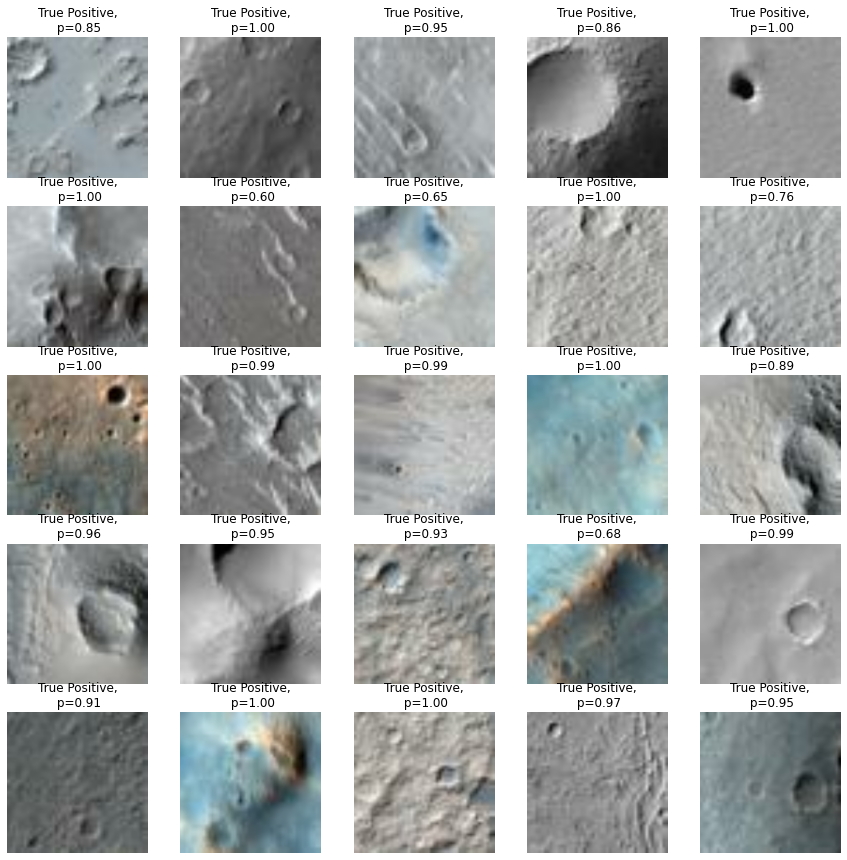

In [248]:
# inspect True positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_positives[i]['image'].numpy().astype("uint8"))
    pred_float = true_positives[i]['pred']
    plt.title(f"True Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

It definitely does seem like the more obvious craters are detected. One thing I am noticing is that in the true positives the backgrounds are much more uniform. In the false negatives (fail to detect a crater that is there) the backgrounds are much more colorful. 

In [221]:
all_probabilities = [] 

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        all_probabilities.append(pred_float)

Text(0, 0.5, 'N')

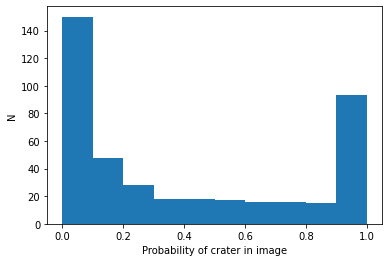

In [223]:
# Plot distribution of actual probabilities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_probabilities)
ax.set_xlabel('Probability of crater in image')
ax.set_ylabel('N')

## ROC - AUC curve

In [234]:
roc_auc_score?

This is about what I got for the titanic survival challenge which isn't bad!

Let's look at some false positives.

In [251]:
false_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_positives.append(fn_dict)

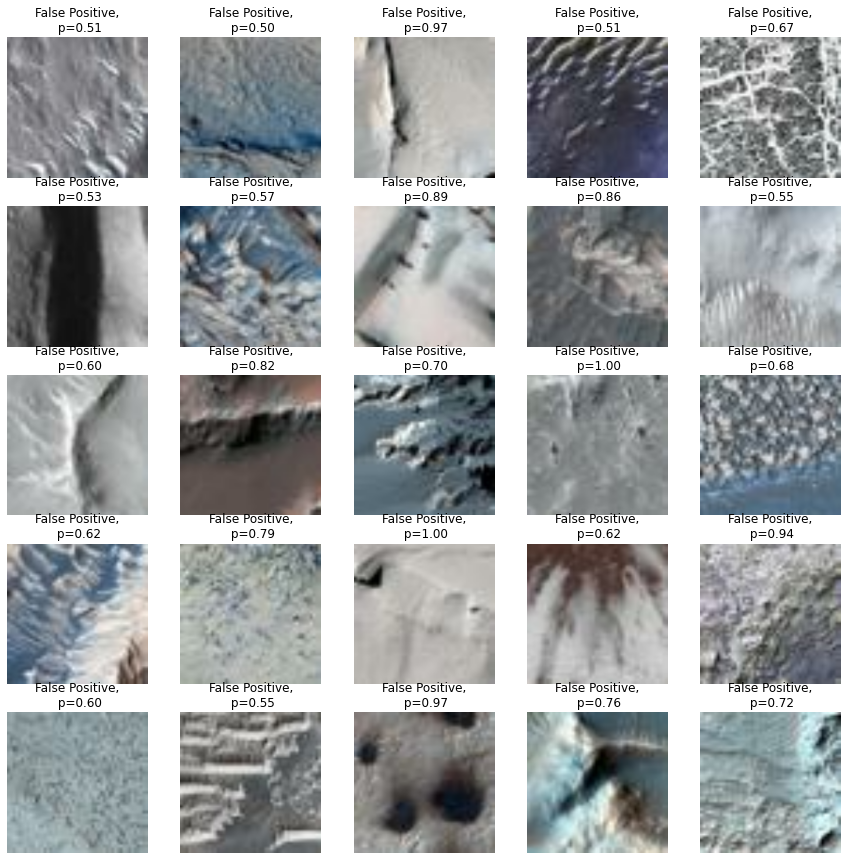

In [252]:
# inspect false positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(false_positives[i]['image'].numpy().astype("uint8"))
    pred_float = false_positives[i]['pred']
    plt.title(f"False Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

These have a similar background color to the true positives, so it might be using background color here. Another reason to use grayscale instead of color images. 

In [253]:
true_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_negatives.append(fn_dict)

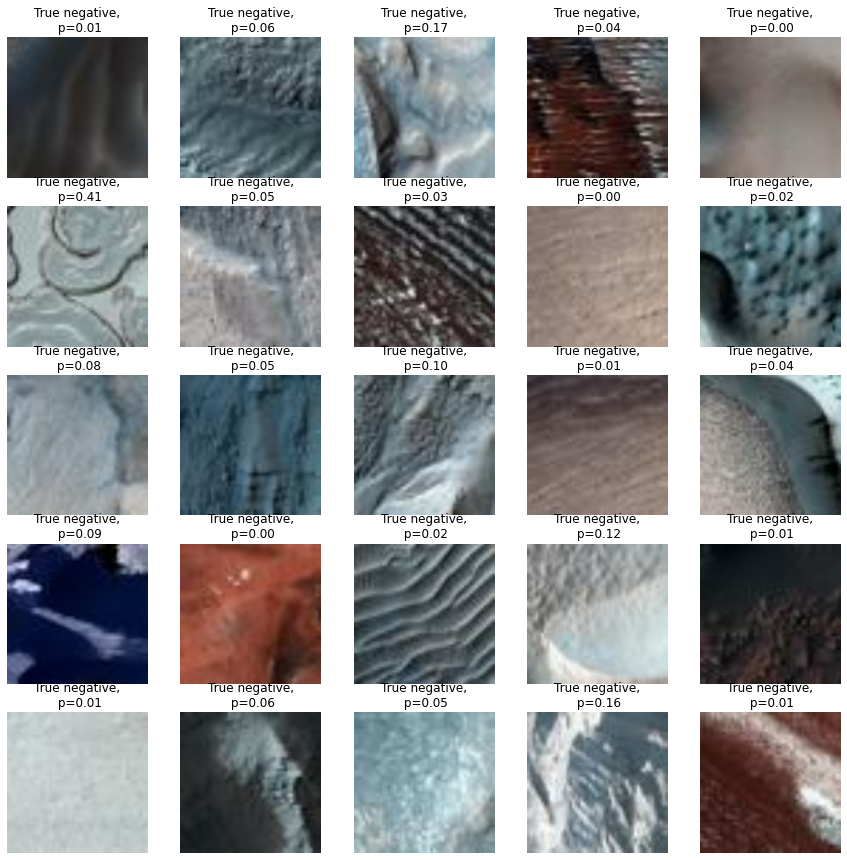

In [256]:
# inspect true negative
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = true_negatives[i]['pred']
    plt.title(f"True negative,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

## Things to do
- Run the model on the rest of the dataset.
- A bigger training/validation set. It's pretty amazing it is doing as well as it is given the limited size of the training set I used.
- Try using grayscale images instead of color. Color might be throwing off the model. 
- Figure out how to do cross validation with this kind of model
- Keras tuner
- Try different CNN architectures
- Try use_multiprocessing=True in model.fit() to see if we get improvement
- Try different image sizes to see if that helps/hurts training
- Purify training/val set to only include obvious craters
- Learn how to look at the intermediate filters in my model

## Done
- Make a test set and evaluate the model on that -- Take a look at confusion matrix/ ROC-AUC curve
